In [15]:
import cv2
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import keras
from keras import regularizers
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Add
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, AveragePooling2D
from keras.losses import categorical_crossentropy
from sklearn.metrics import accuracy_score
from keras.optimizers import Adam, RMSprop
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import os

In [16]:
def row2image(row):
    pixels, emotion = row['pixels'], emotion_map[row['emotion']]
    img = np.array(pixels.split(), dtype=np.uint8)  # Convert pixel values to numpy array
    img = img.reshape(48, 48)
    image = np.stack((img, img, img), axis=-1)  # Stack the grayscale image to form a 3-channel image
    return image, emotion


In [17]:
#Axes to compare number of emotions per dataset
def setup_axe(axe,df,title):
    df['emotion'].value_counts(sort=False).plot(ax=axe, kind='bar', rot=0)
    axe.set_xticklabels(emotion_labels)
    axe.set_xlabel("Emotions")
    axe.set_ylabel("Number")
    axe.set_title(title)
    
    # set individual bar lables using above list
    for i in axe.patches:
        # get_x pulls left or right; get_height pushes up or down
        axe.text(i.get_x()-.05, i.get_height()+120, \
                str(round((i.get_height()), 2)), fontsize=14, color='dimgrey',
                    rotation=0)

In [18]:
def CRNO(df, dataName):
    df['pixels'] = df['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
    data_X = np.array(df['pixels'].tolist(), dtype='float32').reshape(-1,width, height,1)/255.0   
    data_Y = to_categorical(df['emotion'], num_classes)  
    print(dataName, "_X shape:", data_X.shape, dataName, "_Y shape:", data_Y.shape)
    #print(data_X) #[[[0.27450982]
    #print(data_Y) #[[1. 0. 0. ... 0. 0. 0.]
    return data_X, data_Y

In [19]:
def plot_training(results):
    fig, axes = plt.subplots(1,2, figsize=(18, 6))
    # Plot training & validation accuracy values
    axes[0].plot(results.history['acc'])
    axes[0].plot(results.history['val_acc'])
    axes[0].set_title('Model accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    axes[1].plot(results.history['loss'])
    axes[1].plot(results.history['val_loss'])
    axes[1].set_title('Model loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(['Train', 'Validation'], loc='upper left')
    plt.show()

In [20]:
##Functions

#Plotting confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots(figsize=(12,6))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [21]:
# data generator
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)

# early stopping
es = EarlyStopping(monitor='val_accuracy', patience = 5, restore_best_weights=True)

In [26]:
data = pd.read_csv('../Dataset/Dataset/CK+/ckextended.csv')
#check data shape
data.shape

(920, 3)

In [9]:
data.head(15)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
5,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
6,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
7,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
8,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training
9,2,255 254 255 254 254 179 122 107 95 124 149 150...,Training


In [10]:
data.Usage.value_counts()

Usage
Training       28709
PublicTest      3589
PrivateTest     3589
Name: count, dtype: int64

In [27]:
emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion_counts = data['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts

,emotion,number
0,Neutral,593
1,Happy,69
2,NaN,18
3,Angry,45
4,Digust,59
5,Sad,28
6,Fear,25
7,Surprise,83


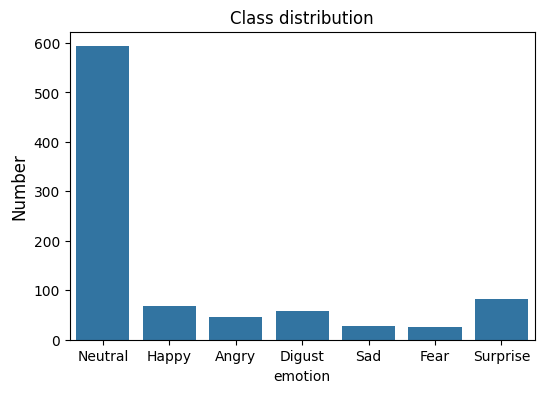

In [28]:
plt.figure(figsize=(6,4))
sns.barplot(x=emotion_counts['emotion'], y=emotion_counts['number'])
plt.title('Class distribution')
plt.ylabel('Number', fontsize=12)
plt.show()


In [ ]:
data['emotion'] = data['emotion'].rank(method='dense').astype(int) - 1

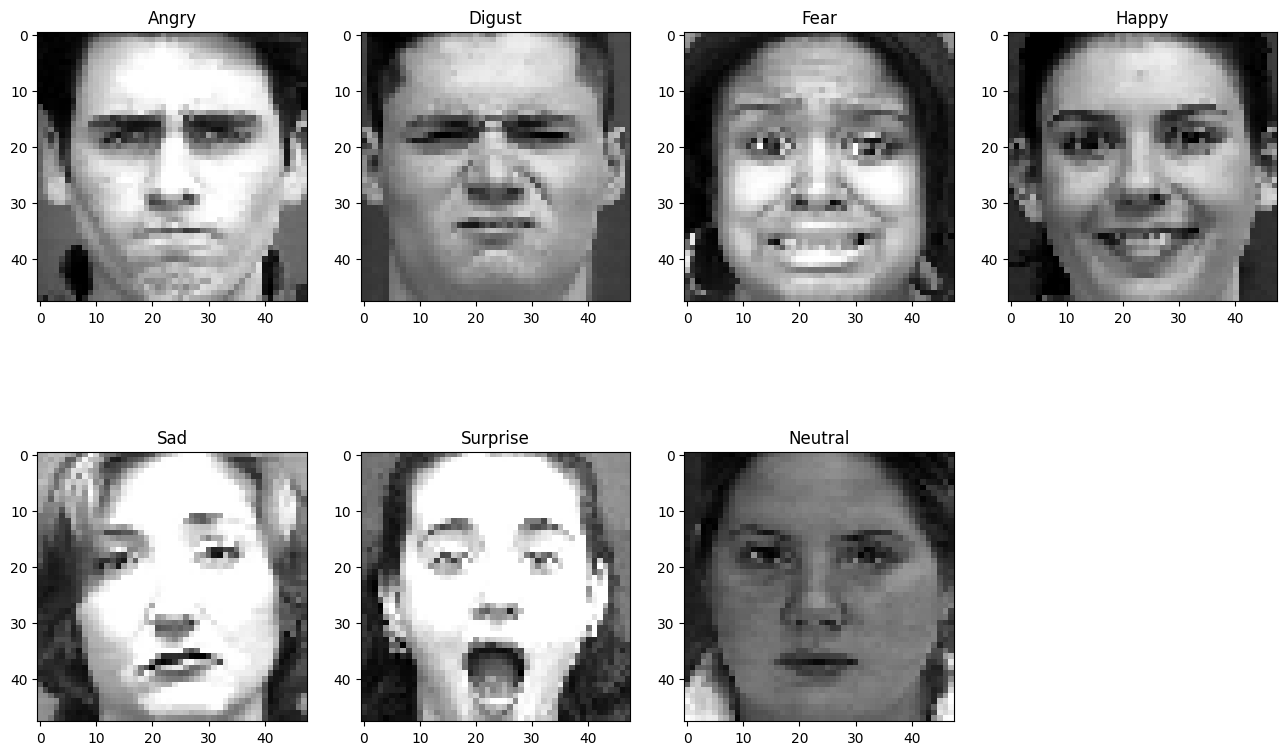

In [29]:
plt.figure(0, figsize=(16,10))
for i in range(1,8):
    face = data[data['emotion'] == i-1].iloc[0]
    img = row2image(face)
    plt.subplot(2,4,i)
    plt.imshow(img[0])
    plt.title(img[1])

plt.show()  

In [ ]:
data_2_path = '../../Dataset/FER2013/RFERD'
data_2_dir_list = os.listdir(data_2_path)

img_data_list = []
emotion_list = []

# Define a mapping from emotion names to numerical labels
emotion_mapping = {
    'anger': 0,
    'contempt': 1,
    'disgust': 2,
    'fear': 3,
    'happiness': 4,
    'neutrality': 5,
    'sadness': 6,
    'surprise': 7
}

for dataset in data_2_dir_list:
    if dataset in emotion_mapping:
        img_list = os.listdir(data_2_path+'/'+ dataset)
        print('Loaded the images of dataset-'+'{}\n'.format(dataset))
        emotion = emotion_mapping[dataset]
        for img in img_list:
            input_img = cv2.imread(data_2_path + '/' + dataset + '/' + img)
            if input_img is not None:
                # Convert BGR to grayscale images
                gray_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
                # Resize to 48 x 48 pixels
                input_img_resize = cv2.resize(gray_img, (48, 48))
                img_data_list.append(input_img_resize.flatten())  # Flatten to a 1D array
                emotion_list.append(emotion)

data_2 = np.array(img_data_list)

# Create a DataFrame
columns = [f'pixel_{i}' for i in range(data_2.shape[1])]
df = pd.DataFrame(data_2, columns=columns)

# Add 'emotion' and 'Usage' columns
df['emotion'] = emotion_list
df['Usage'] = 'Training'  # Assuming all data is used for training

# Concatenate pixel values into a 'pixels' column
df['pixels'] = df.apply(lambda row: ' '.join(row[columns].values.astype(str)), axis=1)

# Drop the individual pixel columns
df = df.drop(columns=columns)

# Reorder columns to match the desired format
df = df[['emotion', 'pixels', 'Usage']]

In [16]:
df.head(5)

,emotion,pixels,Usage
0,0,140 118 100 211 147 157 139 127 139 141 149 19...,Training
1,0,9 7 12 10 13 10 9 9 7 14 14 17 20 13 21 21 29 ...,Training
2,0,171 177 183 184 69 4 17 4 0 0 2 13 51 43 56 86...,Training
3,0,55 183 91 105 112 182 124 65 119 102 163 99 18...,Training
4,0,223 224 224 225 225 225 223 222 238 253 243 24...,Training


In [17]:
df.shape

(5558, 3)

In [18]:
df.Usage.value_counts()

Usage
Training    5558
Name: count, dtype: int64

In [19]:
emotion_map = {0: 'Angry', 1:'Contempt',2: 'Digust', 3: 'Fear', 4: 'Happy', 5: 'Neutral', 6: 'Sad', 7: 'Surprise'}
emotion_counts = df['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts

,emotion,number
0,Angry,890
1,Contempt,208
2,Digust,439
3,Fear,570
4,Happy,1406
5,Neutral,524
6,Sad,746
7,Surprise,775


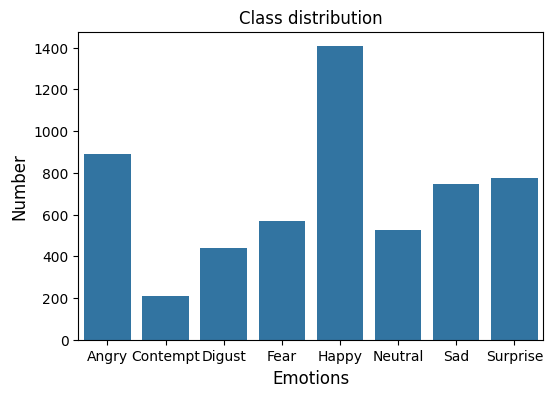

In [20]:
plt.figure(figsize=(6,4))
sns.barplot(x=emotion_counts.emotion, y=emotion_counts.number)
plt.title('Class distribution')
plt.ylabel('Number', fontsize=12)
plt.xlabel('Emotions', fontsize=12)
plt.show()

In [21]:
distinct_values = df['emotion'].unique()
print(distinct_values)

[0 1 2 3 4 5 6 7]


In [22]:
emotion_map = {0: 'Angry', 1:'Contempt',2: 'Digust', 3: 'Fear', 4: 'Happy', 5: 'Neutral', 6: 'Sad', 7: 'Surprise'}
# Define the mapping from the current emotion numbers to the desired order
emotion_mapping = {0: 0, 2: 1, 3: 2, 4: 3, 6: 4, 7: 5, 5: 6}

# Remove rows with emotion 'Contempt'
df = df[df['emotion'] != 1]

# Apply the mapping to create a new 'emotion' column
df['emotion'] = df['emotion'].map(emotion_mapping)

# Fill NaN values with NaN
df['emotion'] = df['emotion'].fillna(np.nan)

# Reset index
df = df.reset_index(drop=True)

In [23]:
distinct_values = df['emotion'].unique()
print(distinct_values)

[0 1 2 3 6 4 5]


In [24]:
emotion_map = {0: 'Angry', 1:'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6:'Neutral'}
emotion_counts = df['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts

,emotion,number
0,Angry,890
1,Disgust,439
2,Fear,570
3,Happy,1406
4,Neutral,524
5,Sad,746
6,Surprise,775


In [25]:
df.shape

(5350, 3)

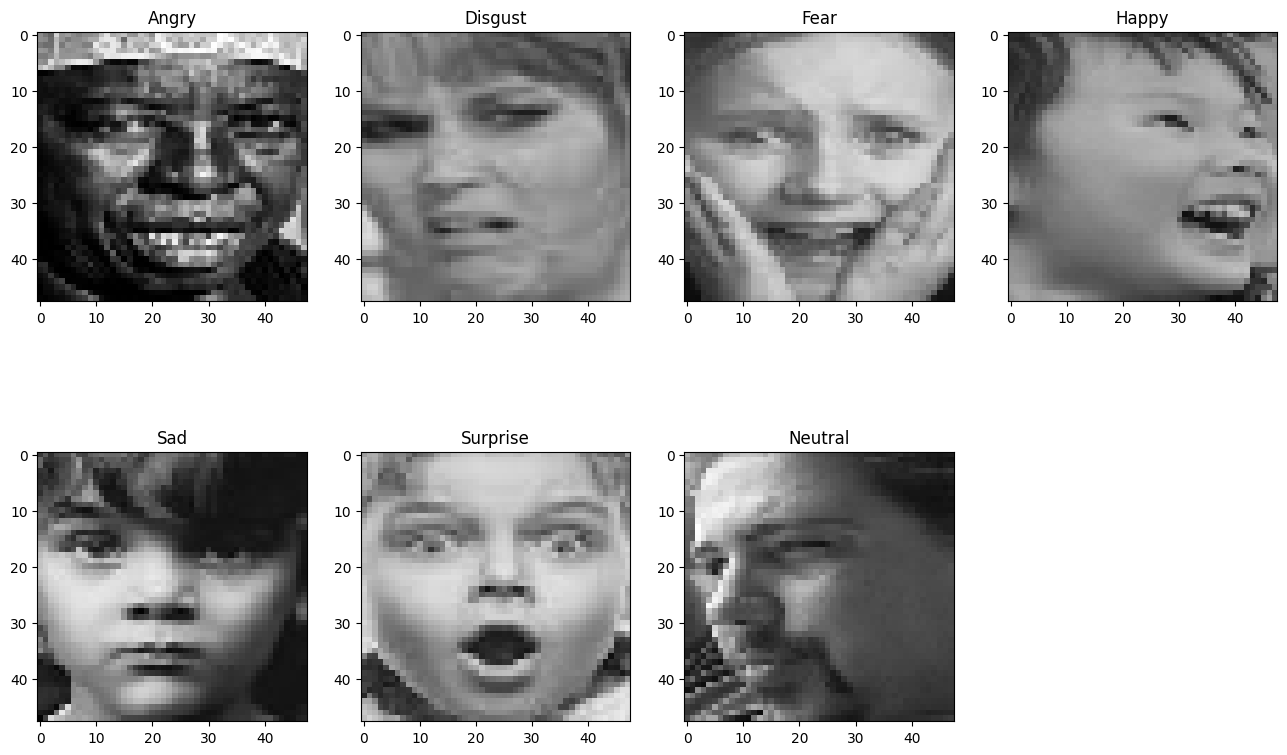

In [26]:
plt.figure(0, figsize=(16,10))
for i in range(1,8):
    face = df[df['emotion'] == i-1].iloc[0]
    img = row2image(face)
    plt.subplot(2,4,i)
    plt.imshow(img[0])
    plt.title(img[1])

plt.show()  

In [102]:
data_train = data[data['Usage']=='Training'].copy()
data_train = pd.concat([data_train, df], ignore_index=True)
data_val = data[data['Usage'] == 'PublicTest'].copy()
data_test = data[data['Usage'] == 'PrivateTest'].copy()
print("train shape: {}, \nvalidation shape: {}, \ntest shape: {}".format(data_train.shape, data_val.shape, data_test.shape))


train shape: (34059, 3), 
validation shape: (3589, 3), 
test shape: (3589, 3)


In [103]:
data_train.emotion.value_counts()

emotion
3    8621
4    5576
6    5489
0    4885
2    4667
5    3946
1     875
Name: count, dtype: int64

In [104]:
data_train = data_train[~data_train['emotion'].isin([1, 2, 5])] 
data_val = data_val[~data_val['emotion'].isin([1, 2, 5])] 
data_test = data_test[~data_test['emotion'].isin([1, 2, 5])] 

emotion_map = {0: 'Angry', 3: 'Happy', 4: 'Sad', 6: 'Neutral'}

emotion_mapping = {0: 0, 3: 1, 4: 2, 6: 3}

data_train['emotion'] = data_train['emotion'].map(emotion_mapping)
data_val['emotion'] = data_val['emotion'].map(emotion_mapping)
data_test['emotion'] = data_test['emotion'].map(emotion_mapping)

# print(data_train['emotion'].unique())  


In [105]:
data_train.emotion.value_counts()

emotion
1    8621
2    5576
3    5489
0    4885
Name: count, dtype: int64

In [106]:
def row3image(row, emotion_map):
    pixels, emotion = row['pixels'], emotion_map[row['emotion']]
    img = np.array(pixels.split(), dtype=np.uint8)  # Convert pixel values to numpy array
    img = img.reshape(48, 48)
    image = np.stack((img, img, img), axis=-1)  # Stack the grayscale image to form a 3-channel image
    return image, emotion

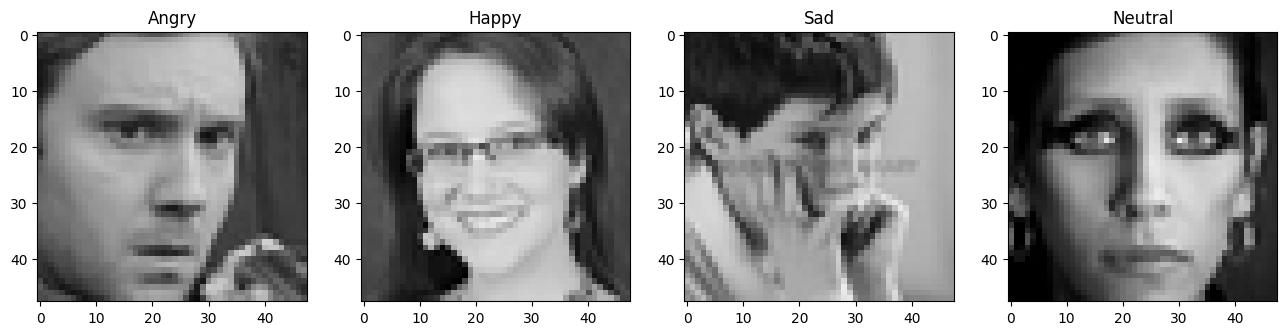

In [109]:
emotion_map = {0: 'Angry',  1: 'Happy', 2: 'Sad', 3: 'Neutral'}

plt.figure(0, figsize=(16,10))
for i in range(4):  # Adjust range to match emotion indices
    face = data_train[data_train['emotion'] == i].iloc[0]  # Use i directly without subtracting 1
    img = row3image(face, emotion_map)
    plt.subplot(2, 4, i+1)  # Increment i by 1 to start subplot index from 1
    plt.imshow(img[0])
    plt.title(img[1])

plt.show()

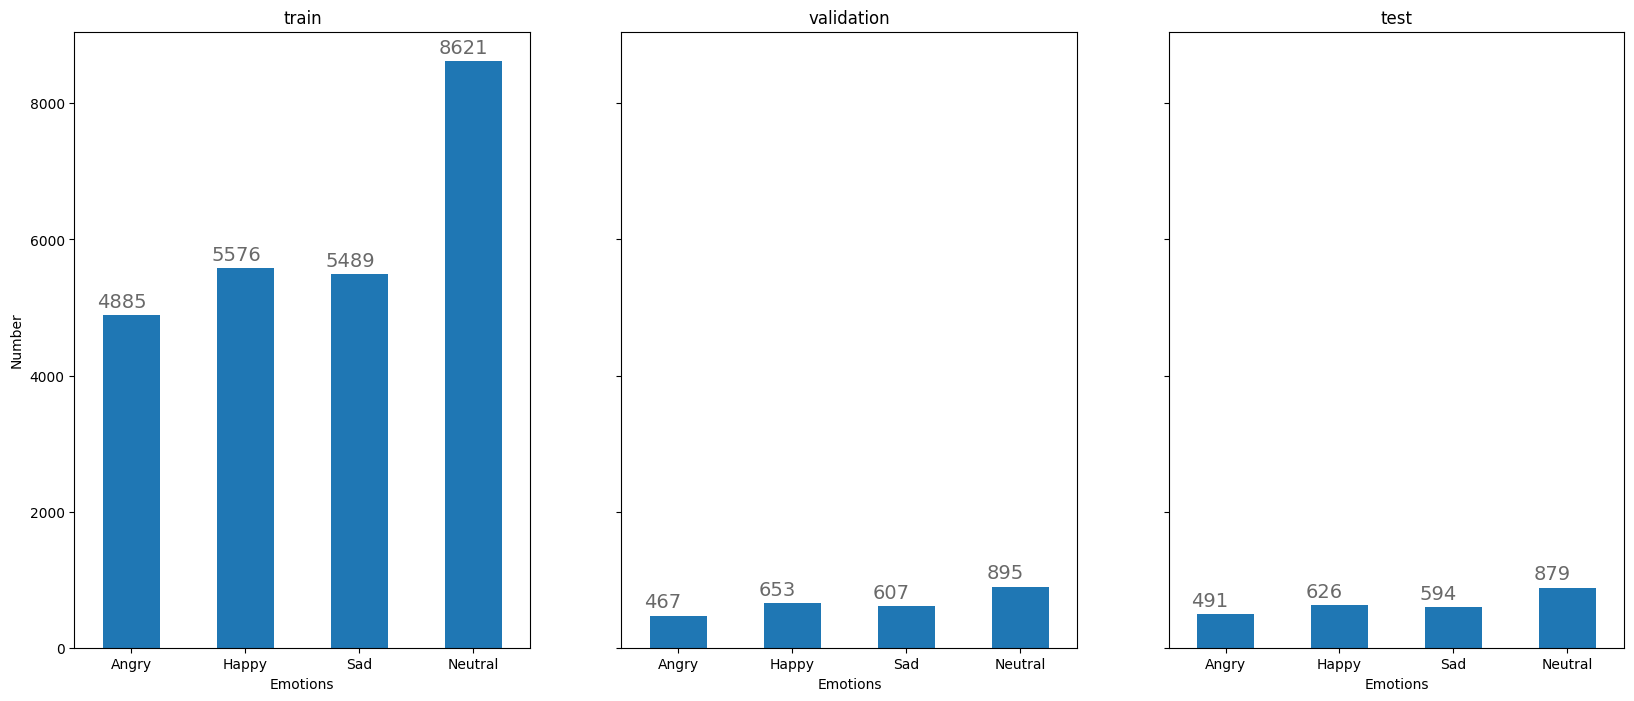

In [111]:
emotion_labels = ['Angry', 'Happy', 'Sad', 'Neutral']

fig, axes = plt.subplots(1,3, figsize=(20,8), sharey=True)
setup_axe(axes[0],data_train,'train')
setup_axe(axes[1],data_val,'validation')
setup_axe(axes[2],data_test,'test')
plt.show()

In [113]:
num_classes = 4
width, height = 48, 48
num_epochs = 100
batch_size = 32

train_X, train_Y = CRNO(data_train, "train") #training data
val_X, val_Y     = CRNO(data_val, "val") #validation data
test_X, test_Y   = CRNO(data_test, "test") #test data

train _X shape: (24571, 48, 48, 1) train _Y shape: (24571, 4)
val _X shape: (2622, 48, 48, 1) val _Y shape: (2622, 4)
test _X shape: (2590, 48, 48, 1) test _Y shape: (2590, 4)


In [114]:
#VGG-16 Model
model_1 = Sequential()

# Module 1
model_1.add(Conv2D(64, kernel_size=(3, 3), input_shape=(width, height, 1), padding='same'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Module 2
model_1.add(Conv2D(128, kernel_size=(3, 3), padding='same'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(Conv2D(128, kernel_size=(3, 3), padding='same'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Module 3
model_1.add(Conv2D(256, kernel_size=(3, 3), padding='same'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(Conv2D(256, kernel_size=(3, 3), padding='same'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(Conv2D(256, kernel_size=(3, 3), padding='same'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Flatten
model_1.add(Flatten())

# Dense layers
model_1.add(Dense(4096))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(Dense(4096))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(Dense(num_classes, activation='softmax'))

model_1.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['accuracy'])

model_1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_27 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 activation_27 (Activation)  (None, 48, 48, 64)        0         
                                                                 
 conv2d_22 (Conv2D)          (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_28 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 activation_28 (Activation)  (None, 48, 48, 64)       

In [115]:
history_1 = model_1.fit(data_generator.flow(train_X, train_Y, batch_size),
                                steps_per_epoch=len(train_X) / batch_size,
                                epochs=num_epochs,
                                verbose=2, 
                                callbacks = [es],
                                validation_data=(val_X, val_Y))

Epoch 1/100
767/767 - 532s - loss: 1.5588 - accuracy: 0.3851 - val_loss: 4.5802 - val_accuracy: 0.3829 - 532s/epoch - 692ms/step
Epoch 2/100
767/767 - 529s - loss: 1.2098 - accuracy: 0.5044 - val_loss: 4.6090 - val_accuracy: 0.3097 - 529s/epoch - 689ms/step
Epoch 3/100
767/767 - 528s - loss: 1.0784 - accuracy: 0.5697 - val_loss: 1.0462 - val_accuracy: 0.5820 - 528s/epoch - 687ms/step
Epoch 4/100
767/767 - 529s - loss: 0.9925 - accuracy: 0.5998 - val_loss: 0.8843 - val_accuracy: 0.6274 - 529s/epoch - 689ms/step
Epoch 5/100
767/767 - 527s - loss: 0.8849 - accuracy: 0.6397 - val_loss: 0.8394 - val_accuracy: 0.6560 - 527s/epoch - 686ms/step
Epoch 6/100
767/767 - 528s - loss: 0.8396 - accuracy: 0.6608 - val_loss: 0.8207 - val_accuracy: 0.6602 - 528s/epoch - 688ms/step
Epoch 7/100
767/767 - 524s - loss: 0.8071 - accuracy: 0.6726 - val_loss: 0.9222 - val_accuracy: 0.6251 - 524s/epoch - 683ms/step
Epoch 8/100
767/767 - 577s - loss: 0.7796 - accuracy: 0.6864 - val_loss: 0.7995 - val_accuracy: 0

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
test_true = np.argmax(test_Y, axis=1)
test_pred = np.argmax(model_1.predict(test_X), axis=1)
vgg_16_score = accuracy_score(test_true, test_pred)
print("1.VGG-16 CNN Model Accuracy on test set: {:.4f}".format(accuracy_score(test_true, test_pred)))

In [ ]:
plot_confusion_matrix(test_true, test_pred, classes=emotion_labels, normalize=True, title='Normalized confusion matrix')
plt.show()

In [126]:
model_3 = Sequential()

# Initial Convolutional layer
model_3.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(width, height, 1)))
model_3.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model_3.add(BatchNormalization())
model_3.add(MaxPooling2D(2, 2))
model_3.add(Dropout(0.25))

model_3.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
model_3.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_3.add(BatchNormalization())
model_3.add(MaxPooling2D(pool_size=(2, 2)))
model_3.add(Dropout(0.25))

model_3.add(Flatten())
model_3.add(Dense(1024, activation='relu'))
model_3.add(Dropout(0.5))
    
model_3.add(Dense(num_classes, activation='softmax'))

model_3.compile(optimizer=Adam(learning_rate=0.0001, decay=1e-6), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Display model summary
model_3.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 48, 48, 32)        320       
                                                                 
 conv2d_33 (Conv2D)          (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization_38 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 conv2d_34 (Conv2D)          (None, 24, 24, 128)      

In [127]:
history_3 = model_3.fit(data_generator.flow(train_X, train_Y, batch_size),
                                steps_per_epoch=len(train_X) / batch_size,
                                epochs=100,
                                verbose=2, 
                                callbacks = [es],
                                validation_data=(val_X, val_Y))

Epoch 1/100


767/767 - 396s - loss: 3.7807 - accuracy: 0.3556 - val_loss: 3.2297 - val_accuracy: 0.4348 - 396s/epoch - 516ms/step
Epoch 2/100
767/767 - 395s - loss: 2.8444 - accuracy: 0.4208 - val_loss: 2.4038 - val_accuracy: 0.4928 - 395s/epoch - 515ms/step
Epoch 3/100
767/767 - 402s - loss: 2.1971 - accuracy: 0.4728 - val_loss: 1.8416 - val_accuracy: 0.5500 - 402s/epoch - 524ms/step
Epoch 4/100
767/767 - 410s - loss: 1.7342 - accuracy: 0.5224 - val_loss: 1.4950 - val_accuracy: 0.5820 - 410s/epoch - 534ms/step
Epoch 5/100
767/767 - 410s - loss: 1.4284 - accuracy: 0.5679 - val_loss: 1.3471 - val_accuracy: 0.5717 - 410s/epoch - 534ms/step
Epoch 6/100
767/767 - 422s - loss: 1.2398 - accuracy: 0.5995 - val_loss: 1.1367 - val_accuracy: 0.6163 - 422s/epoch - 549ms/step
Epoch 7/100
767/767 - 418s - loss: 1.1192 - accuracy: 0.6192 - val_loss: 1.0643 - val_accuracy: 0.6377 - 418s/epoch - 544ms/step
Epoch 8/100
767/767 - 418s - loss: 1.0378 - accuracy: 0.6344 - val_loss: 0.9863 - val_accuracy: 0.6449 - 418s

In [138]:
test_true = np.argmax(test_Y, axis=1)
test_pred = np.argmax(model_3.predict(test_X), axis=1)
improved_vgg_16_score = accuracy_score(test_true, test_pred)
print("3. Improved VGG-16 Inspired CNN Model Accuracy on test set: {:.4f}".format(accuracy_score(test_true, test_pred)))

81/81 [==============================] - 7s 91ms/step
3. Improved VGG-16 Inspired CNN Model Accuracy on test set: 0.7236


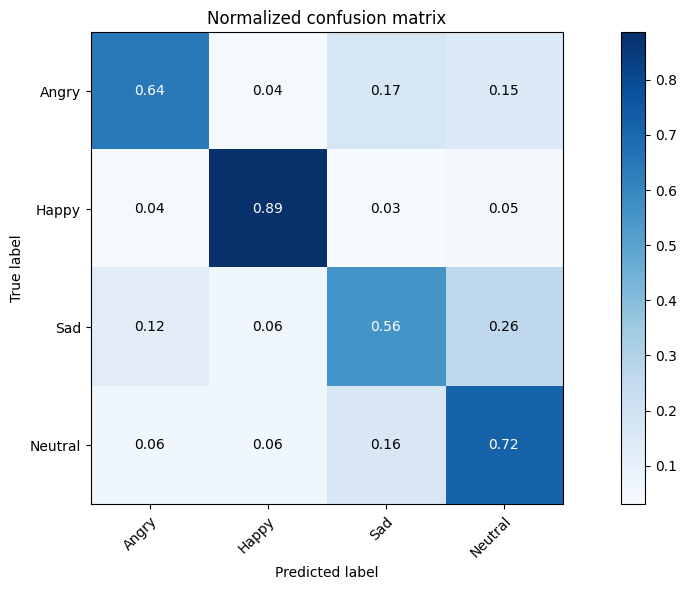

In [133]:
plot_confusion_matrix(test_true, test_pred, classes=emotion_labels, normalize=True, title='Normalized confusion matrix')
plt.show()


In [142]:
model_1.save('../Recognition/Model/FER_v3.h5')